In [7]:
#Check GPU
!nvidia-smi

Sat Jun 29 00:16:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              8W /   35W |     319MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Architecture 
# custom_yolov8.yaml

#*model:
# type: yolo
# backbone:
#   type: CSPDarknet53  # chosen backbone
#   args:
#      depth: 53
#  neck:
#    type: BIFpNN  # new neck component
#    args:
#      in_channels_list: [256, 512, 1024]
#      out_channels: 256
# head:
#    type: YOLOv8Head
#    args:
#      in_channels: [256, 256, 256]
#      num_classes: 80  # number of classes


In [8]:
#Verifying Cuda Support
import torch

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    
    cuda_version = torch.version.cuda
    print(f"CUDA version: {cuda_version}")

     
    cudnn_version = torch.backends.cudnn.version()
    print(f"cuDNN version: {cudnn_version}")
else:
    print("CUDA is not available on this system.")

CUDA available: True
CUDA version: 11.7
cuDNN version: 8500


In [ ]:
# BiFPN Architecture
import torch
import torch.nn as nn

class BIFpNN(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(BIFpNN, self).__init__()
        self.lateral_convs = nn.ModuleList()
        self.fpn_convs = nn.ModuleList()

        for in_channels in in_channels_list:
            self.lateral_convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
            self.fpn_convs.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

    def forward(self, inputs):
        
        laterals = [lateral_conv(inputs[i]) for i, lateral_conv in enumerate(self.lateral_convs)]

        
        for i in range(len(laterals) - 2, -1, -1):
            laterals[i] += nn.functional.interpolate(laterals[i + 1], size=laterals[i].shape[-2:], mode='nearest')

        
        outs = [self.fpn_convs[i](laterals[i]) for i in range(len(laterals))]

        return tuple(outs)


In [2]:
#Training the alternate model
#I HAVE CHANGED THE ARCHITECTURE FOR YOLOV8 NANO VERSION
from ultralytics import YOLO
from BIFpNN import BIFpNN  # Correct the import path

class CustomYOLO(YOLO):
    def __init__(self, cfg='yolov8.yaml'):
        super().__init__(cfg)
        self.neck = BIFpNN(in_channels_list=[256, 512, 1024], out_channels=256)

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.head(x)
        return x

model = CustomYOLO()
model.train(data='mydata.yaml', epochs=25, batch=16)


WARNING  no model scale passed. Assuming scale='n'.
New https://pypi.org/project/ultralytics/8.2.46 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.45  Python-3.10.7 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8.yaml, data=mydata.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cl

train: Scanning C:\Users\kalas\OneDrive\Desktop\IIRS\train\labels.cache... 2504 images, 973 backgrounds, 0 corrupt: 100%|██████████| 2504/2504 [00:00<?, ?it/s]
c:\Users\kalas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\kalas\OneDrive\Desktop\IIRS\valid\labels.cache... 512 images, 185 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.42G      3.492      5.157      4.167          3        640: 100%|██████████| 157/157 [00:31<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.05it/s]

                   all        512        631        0.1     0.0856       0.02    0.00566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.39G        3.1      3.518      3.247          5        640: 100%|██████████| 157/157 [00:28<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.49it/s]


                   all        512        631      0.102       0.16     0.0458     0.0142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.33G      2.886      2.999      2.988          8        640: 100%|██████████| 157/157 [00:28<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        512        631      0.191      0.155     0.0679     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.47G      2.677      2.679       2.81         11        640: 100%|██████████| 157/157 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.30it/s]


                   all        512        631      0.263      0.157      0.106     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.42G      2.534       2.53      2.628         13        640: 100%|██████████| 157/157 [00:28<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.14it/s]


                   all        512        631      0.218      0.244      0.132     0.0409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       2.4G       2.38      2.434      2.504         11        640: 100%|██████████| 157/157 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


                   all        512        631      0.301      0.246      0.173     0.0544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.47G      2.223      2.251      2.361          5        640: 100%|██████████| 157/157 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.67it/s]

                   all        512        631      0.358      0.338      0.235     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.37G      2.082      2.067      2.228          4        640: 100%|██████████| 157/157 [00:28<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.81it/s]

                   all        512        631      0.322      0.352      0.235     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.29G      2.082      2.083      2.227          9        640: 100%|██████████| 157/157 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]

                   all        512        631      0.281      0.379      0.246     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.42G      2.007      2.058      2.169         25        640: 100%|██████████| 157/157 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        512        631      0.356      0.326      0.234     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.41G      1.967      1.991        2.1         10        640: 100%|██████████| 157/157 [00:28<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.58it/s]

                   all        512        631      0.376      0.311      0.273     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       2.3G      1.863      1.886      2.047         10        640: 100%|██████████| 157/157 [00:28<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        512        631      0.457      0.416      0.359      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.26G      1.879      1.875      2.036         14        640: 100%|██████████| 157/157 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.59it/s]

                   all        512        631      0.491      0.474      0.412      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.25G      1.843      1.847      1.989         15        640: 100%|██████████| 157/157 [00:28<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.59it/s]

                   all        512        631      0.485      0.407      0.392      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.26G       1.79      1.741      1.938          8        640: 100%|██████████| 157/157 [00:28<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.66it/s]

                   all        512        631       0.52      0.469      0.438      0.192


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.29G      1.775      1.822      1.991          7        640: 100%|██████████| 157/157 [00:28<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]

                   all        512        631      0.486      0.412      0.375      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.26G      1.714      1.703       1.96          4        640: 100%|██████████| 157/157 [00:28<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.58it/s]

                   all        512        631       0.54      0.426      0.446      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       2.3G      1.691      1.656      1.934          6        640: 100%|██████████| 157/157 [00:27<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.54it/s]

                   all        512        631      0.494      0.412      0.383      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.25G      1.649      1.653      1.915         11        640: 100%|██████████| 157/157 [00:27<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.68it/s]

                   all        512        631      0.544      0.456       0.44      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.41G      1.623      1.586      1.899          5        640: 100%|██████████| 157/157 [00:27<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.56it/s]

                   all        512        631      0.625      0.428      0.475      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.38G      1.614      1.547      1.882          4        640: 100%|██████████| 157/157 [00:27<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]

                   all        512        631      0.522      0.478      0.467      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       2.4G      1.568      1.496      1.852          5        640: 100%|██████████| 157/157 [00:27<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.78it/s]

                   all        512        631      0.597      0.479      0.501      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25       2.3G      1.498      1.453      1.787          5        640: 100%|██████████| 157/157 [00:27<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.69it/s]

                   all        512        631      0.596      0.488      0.508      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.29G      1.481      1.476      1.797          5        640: 100%|██████████| 157/157 [00:27<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.72it/s]

                   all        512        631      0.578      0.483      0.507       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.39G      1.497      1.443      1.777          3        640: 100%|██████████| 157/157 [00:27<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.77it/s]

                   all        512        631      0.627      0.534      0.558      0.285



25 epochs completed in 0.228 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.45  Python-3.10.7 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
YOLOv8 summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


                   all        512        631       0.62      0.534      0.556      0.284
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DEF344AA40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [9]:
!pip install pillow

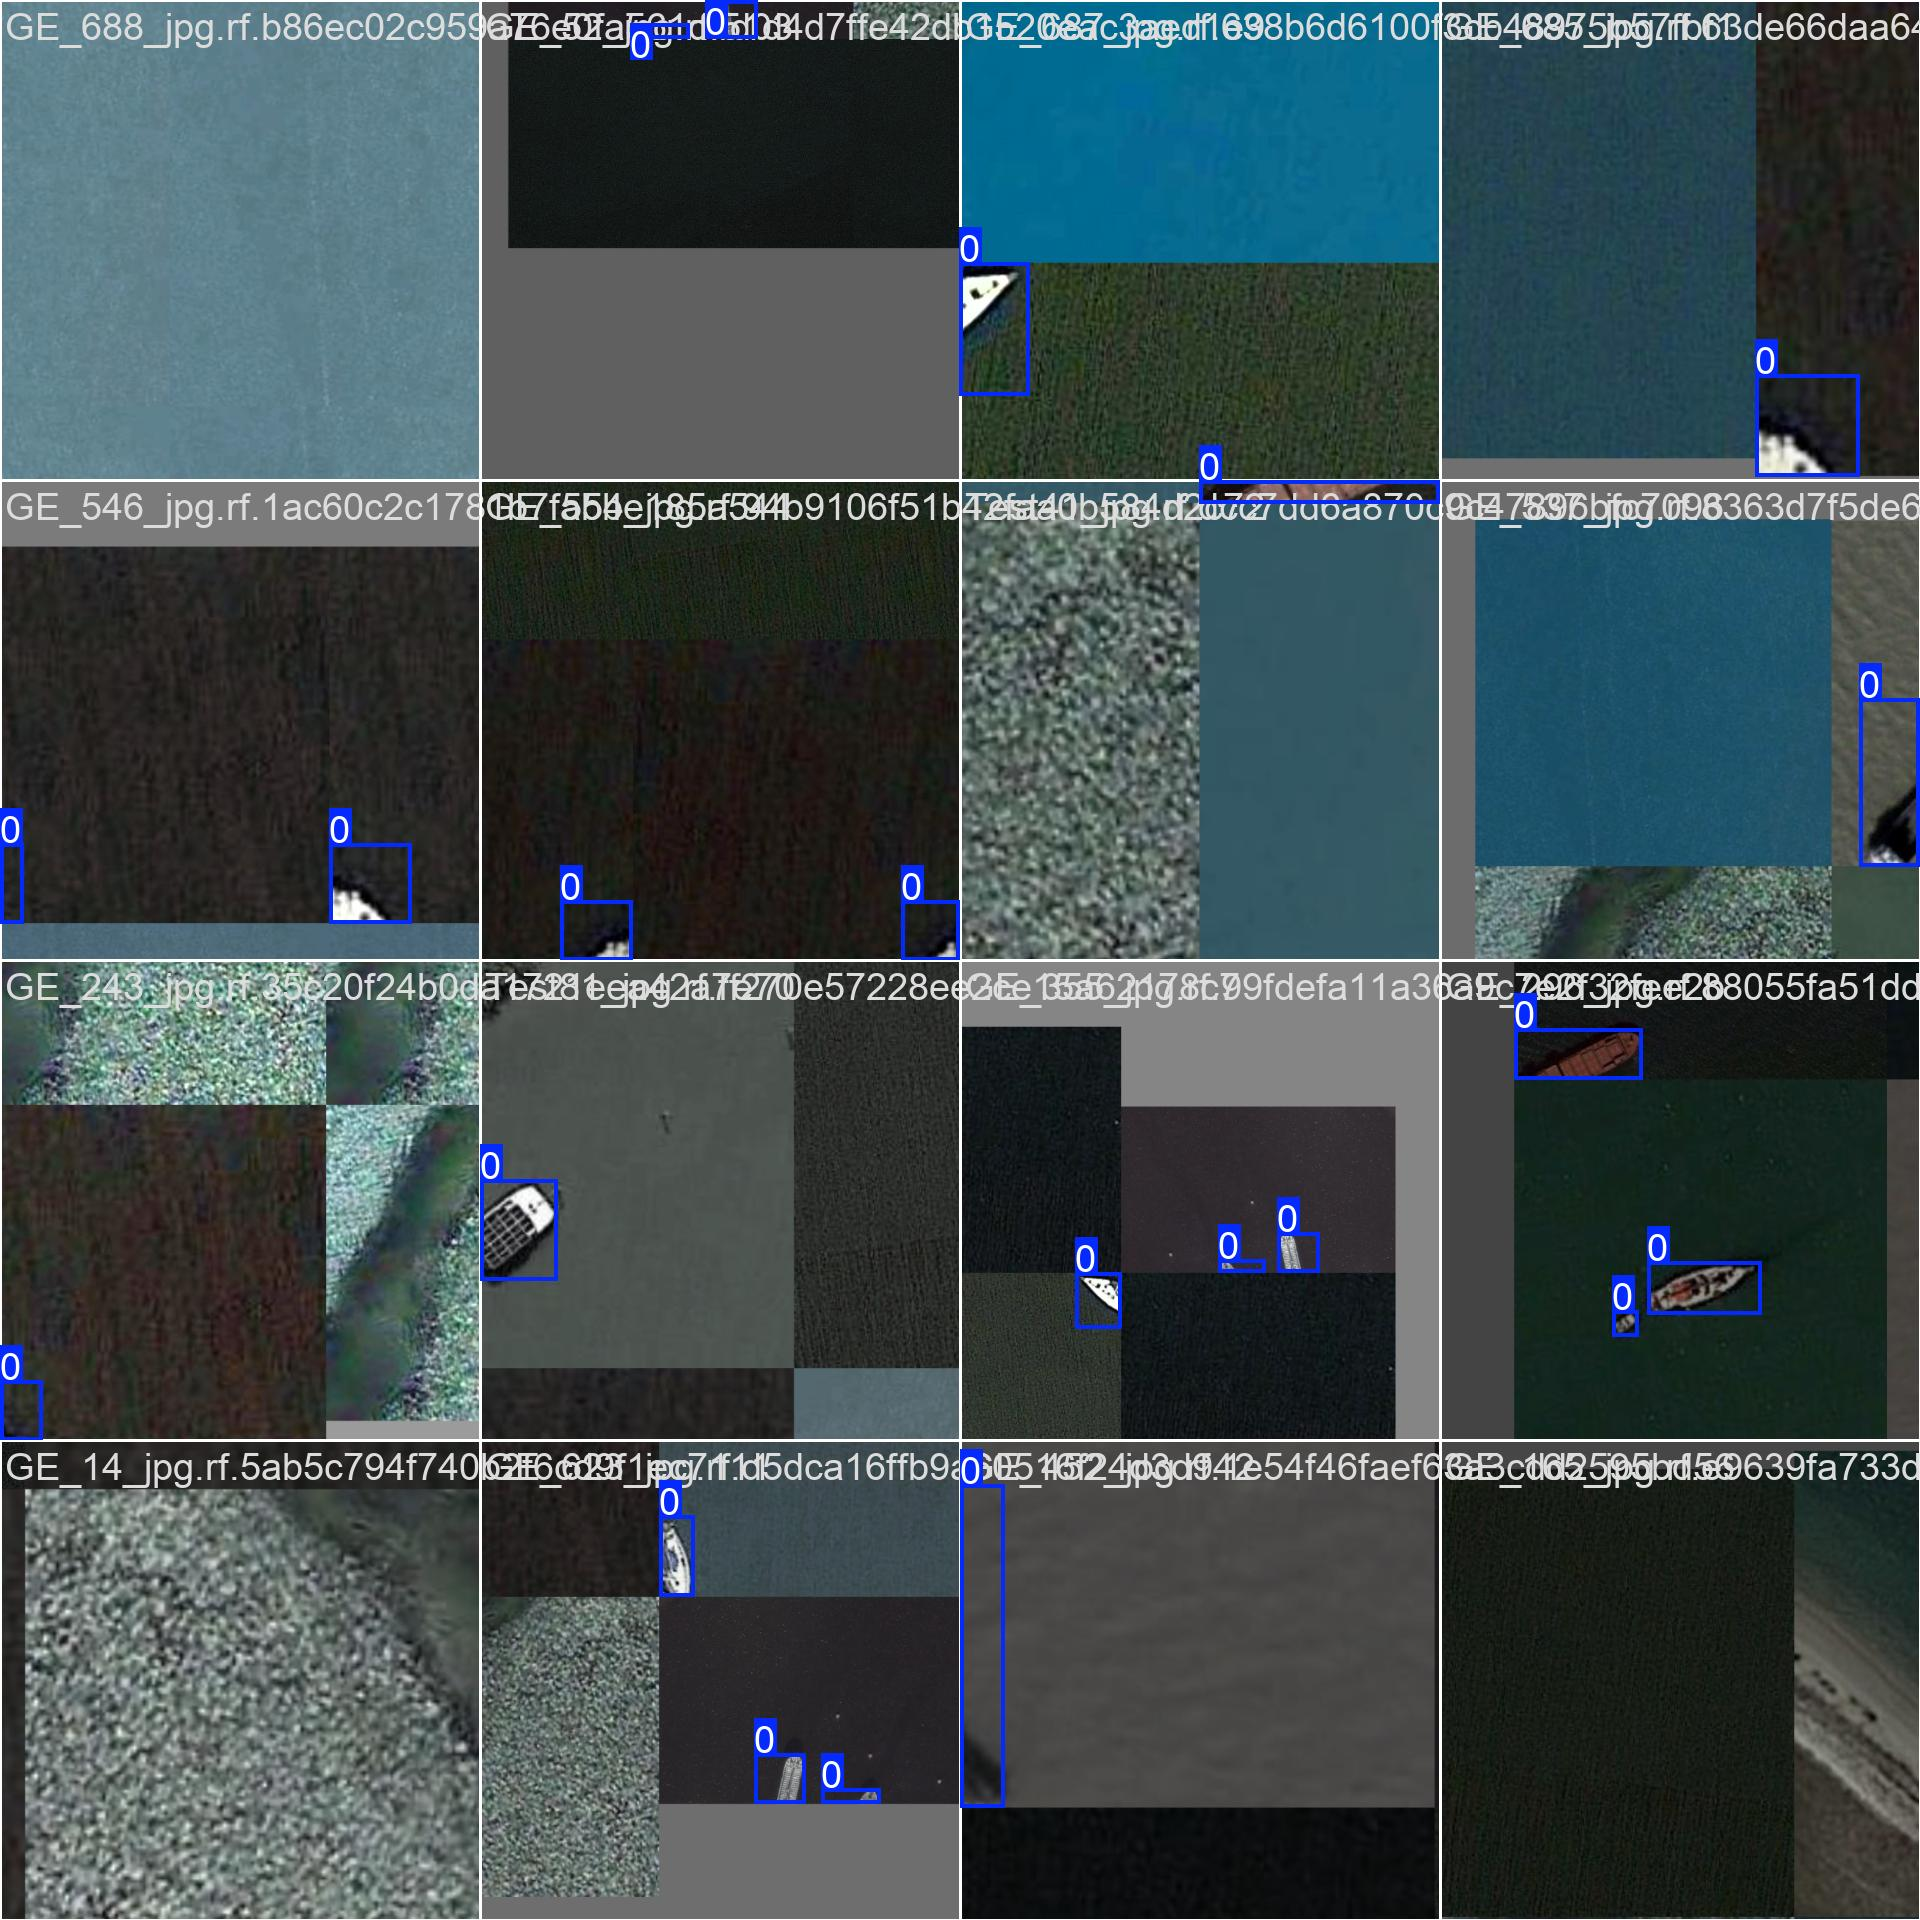

In [13]:
#Training Data
from IPython.display import display, Image
from PIL import Image as PILImage


image_path = "runs/detect/train/train_batch1.jpg"
img = PILImage.open(image_path)


display(img)


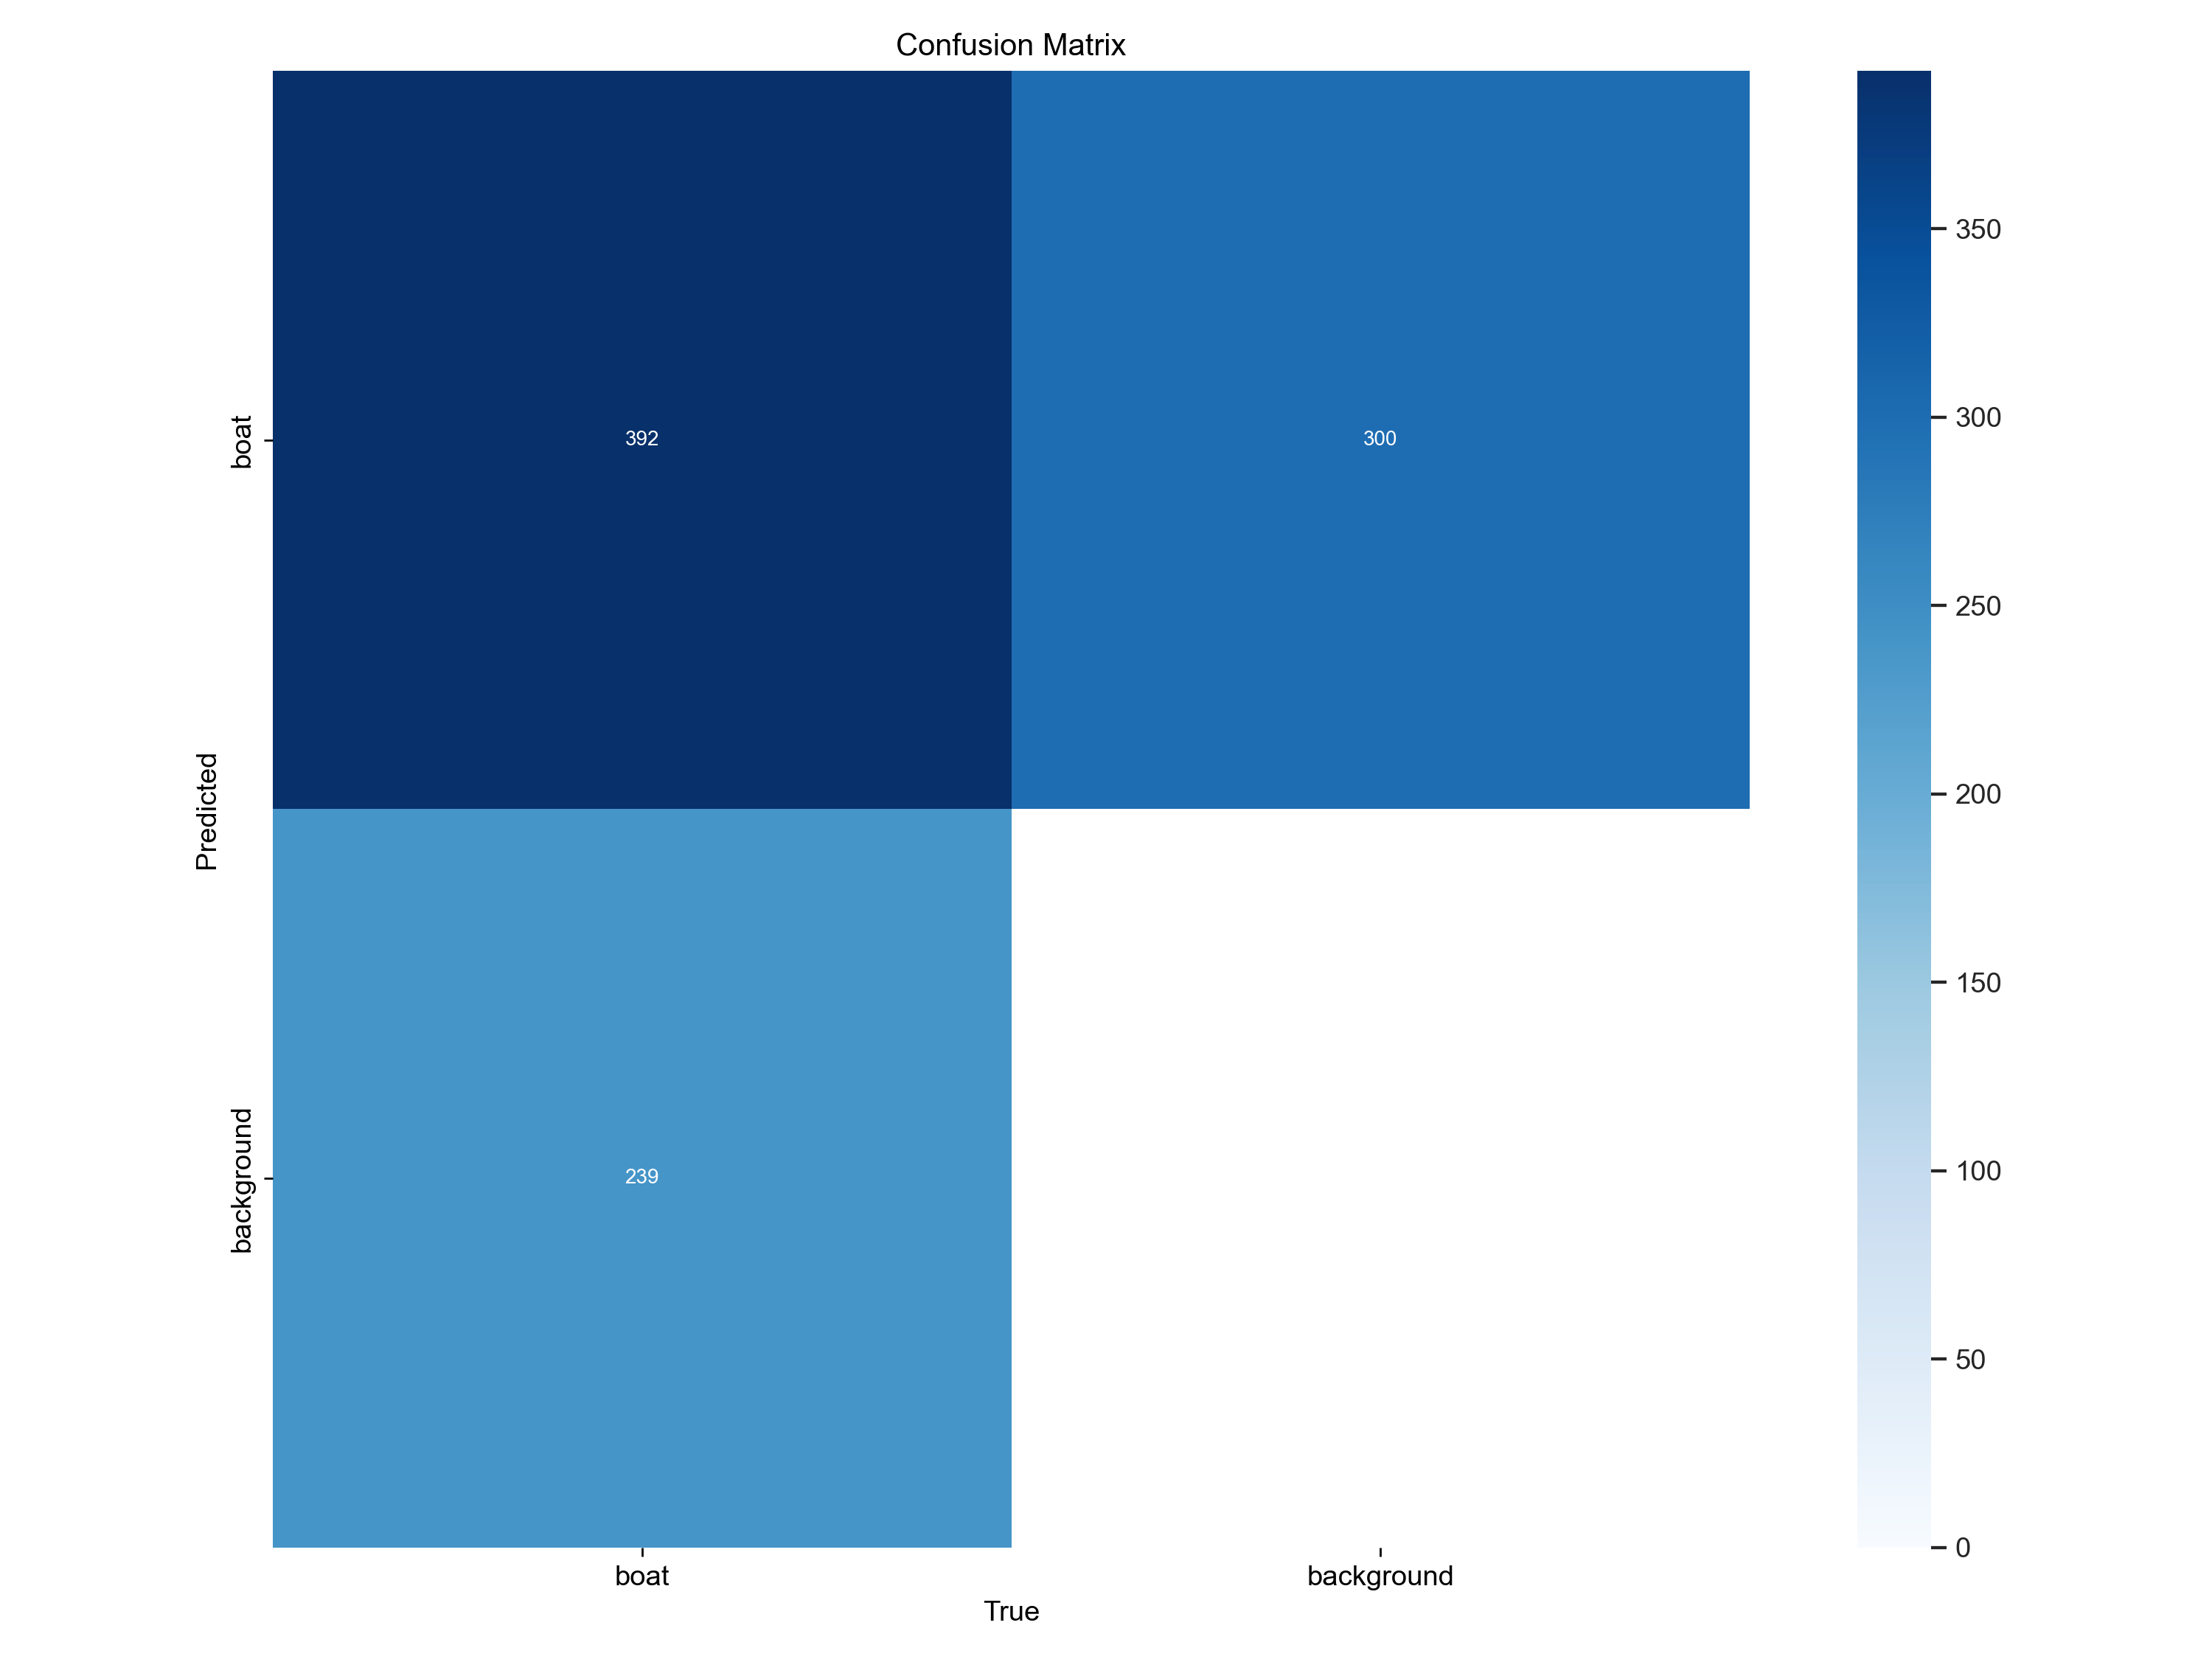

In [17]:
#Confusion Matrix
from IPython.display import display, Image
from PIL import Image as PILImage


image_path = "runs/detect/train/confus.png"
img = PILImage.open(image_path)


display(img)


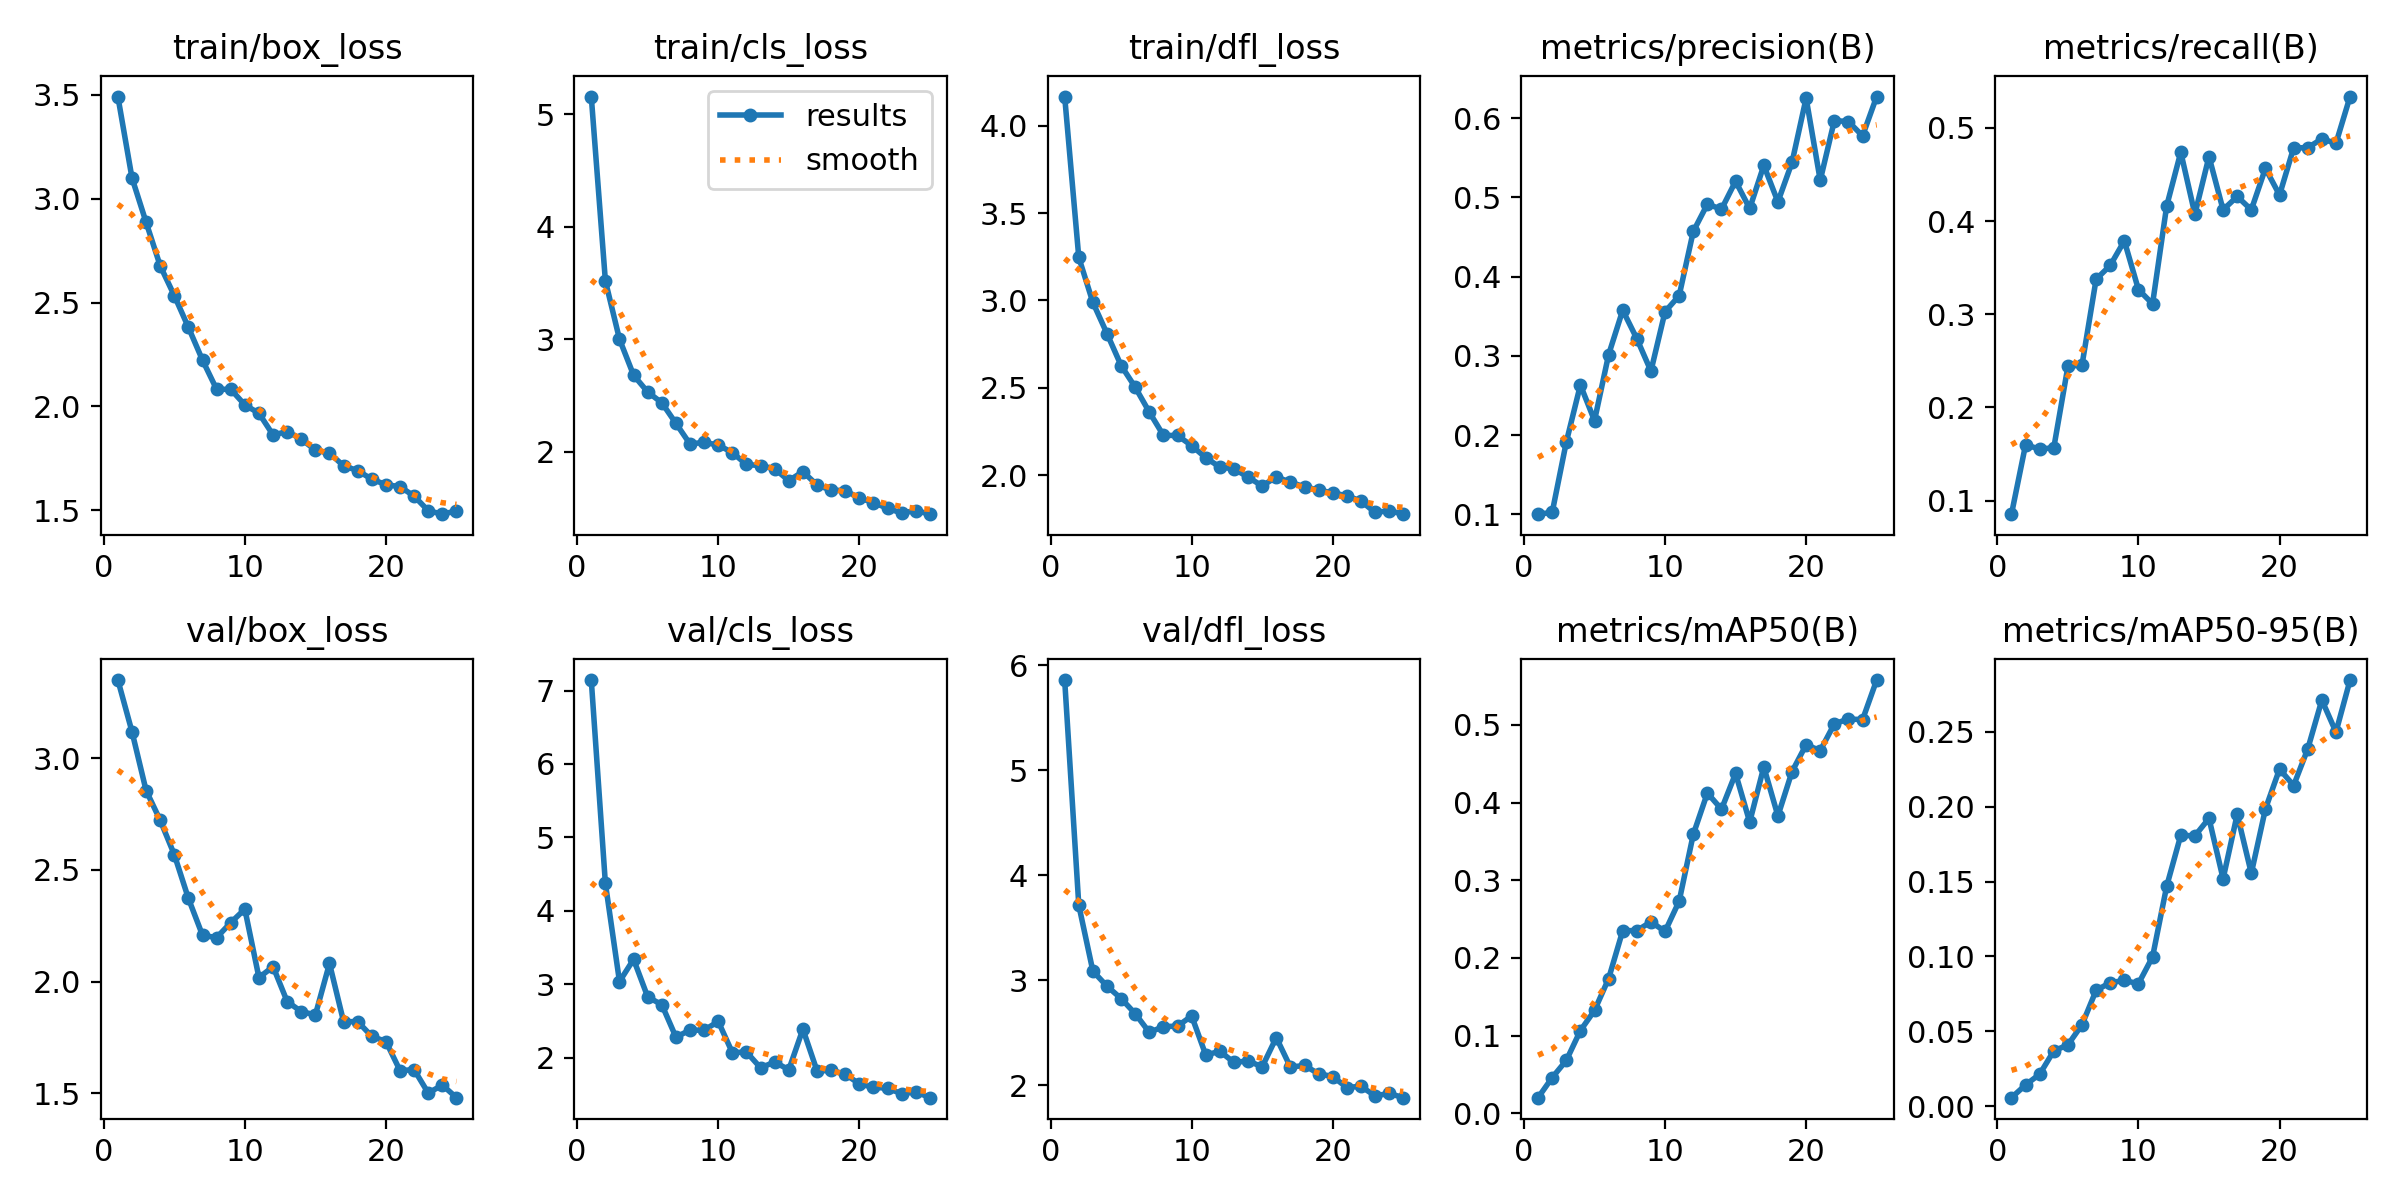

In [18]:
#Confusion Matrix
from IPython.display import display, Image
from PIL import Image as PILImage


image_path = "runs/detect/train/results.png"
img = PILImage.open(image_path)


display(img)
